In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib  # Para leer archivos de formato NIfTI
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp # Biblioteca de alto nivel para modelos de segmentación
from tqdm import tqdm # Para barras de progreso
from sklearn.model_selection import train_test_split
import cv2 # OpenCV para manipulación de imágenes como redimensionamiento y superposición

# Importaciones para XAI (Grad-CAM)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

RuntimeError: operator torchvision::nms does not exist

In [38]:
# Configuración del dispositivo (GPU si está disponible, de lo contrario CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


In [ ]:
# ==============================================================================
# SECCIÓN 2: DEFINICIÓN DE PARÁMETROS Y RUTAS
# ==============================================================================
# Parámetros globales para el entrenamiento y el procesamiento de datos.

# Ruta al directorio principal que contiene los datos de BraTS 2021
DATA_DIR = 'F:/Proyectos/brain_segmentation/data/BraTS2021_Training_Data/'

# Parámetros del modelo y entrenamiento
IMG_SIZE = 240 # Tamaño al que se redimensionarán las imágenes
BATCH_SIZE = 8
EPOCHS = 25
LEARNING_RATE = 1e-4
ENCODER = 'resnet50'
PRETRAINED_WEIGHTS = 'imagenet'

In [22]:
# ==============================================================================
# SECCIÓN 3: CARGA DE DATOS Y PRE-PROCESAMIENTO
# ==============================================================================
# Funciones para encontrar, cargar y pre-procesar los datos de BraTS.

def get_patient_paths(data_dir):
    """
    Obtiene las rutas a las carpetas de cada paciente.
    """
    patient_folders = glob.glob(os.path.join(data_dir, 'BraTS2021_*'))
    return patient_folders

def preprocess_mask(mask):
    """
    Pre-procesa la máscara de segmentación de BraTS.
    Las etiquetas originales son 1 (NCR), 2 (ED), 4 (ET).
    Se mapean a 1 (NCR), 2 (ED), 3 (ET) para facilitar el manejo en PyTorch.
    La clase 0 es el fondo.
    """
    mask_processed = np.zeros_like(mask)
    mask_processed[mask == 1] = 1  # NCR
    mask_processed[mask == 2] = 2  # ED
    mask_processed[mask == 4] = 3  # ET
    return mask_processed

def load_and_preprocess_sample(patient_path):
    """
    Carga las 4 modalidades de MRI y la máscara para un paciente,
    y las pre-procesa.
    Retorna una lista de pares (imagen_apilada, mascara_procesada) para los cortes con tumor.
    """
    processed_samples = []
    try:
        # Cargar las 4 modalidades y la máscara
        # glob.glob devuelve una lista, tomamos el primer elemento 
        flair_path = glob.glob(os.path.join(patient_path, '*_flair.nii.gz'))
        t1_path = glob.glob(os.path.join(patient_path, '*_t1.nii.gz'))
        t1ce_path = glob.glob(os.path.join(patient_path, '*_t1ce.nii.gz'))
        t2_path = glob.glob(os.path.join(patient_path, '*_t2.nii.gz'))
        seg_path = glob.glob(os.path.join(patient_path, '*_seg.nii.gz'))

        flair_img = nib.load(flair_path[0]).get_fdata()
        t1_img = nib.load(t1_path[0]).get_fdata()
        t1ce_img = nib.load(t1ce_path[0]).get_fdata()
        t2_img = nib.load(t2_path[0]).get_fdata()
        seg_mask = nib.load(seg_path[0]).get_fdata()

        # Iterar a través de los cortes axiales (última dimensión)
        for i in range(flair_img.shape[2]):
            mask_slice = seg_mask[:, :, i]
            
            # Solo procesar cortes que contienen tumor para enfocar el entrenamiento
            if np.sum(mask_slice) > 0:
                # Normalización Z-score para cada modalidad
                flair_slice = (flair_img[:, :, i] - np.mean(flair_img[:, :, i])) / (np.std(flair_img[:, :, i]) + 1e-8)
                t1_slice = (t1_img[:, :, i] - np.mean(t1_img[:, :, i])) / (np.std(t1_img[:, :, i]) + 1e-8)
                t1ce_slice = (t1ce_img[:, :, i] - np.mean(t1ce_img[:, :, i])) / (np.std(t1ce_img[:, :, i]) + 1e-8)
                t2_slice = (t2_img[:, :, i] - np.mean(t2_img[:, :, i])) / (np.std(t2_img[:, :, i]) + 1e-8)

                # Apilar las 4 modalidades para crear una imagen de 4 canales
                # La forma final debe ser (canales, altura, anchura) para PyTorch
                stacked_img = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=0)
                
                # Pre-procesar la máscara
                processed_mask = preprocess_mask(mask_slice)

                processed_samples.append((stacked_img, processed_mask))
        
        return processed_samples

    except Exception as e:
        print(f"Error procesando paciente {patient_path}: {e}")
        return processed_samples # Devolver lista vacía si hay error

In [23]:
# ==============================================================================
# SECCIÓN 4: GENERADOR DE DATOS DE PYTORCH
# ==============================================================================
# Clase Dataset personalizada para manejar los datos de BraTS.

class BraTSDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtener la imagen apilada y la máscara
        image, mask = self.data[idx]
        
        # Convertir a tensores de PyTorch
        # Asegurarse de que los tipos de datos son correctos
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask


In [24]:
# ==============================================================================
# SECCIÓN 5: DEFINICIÓN DEL MODELO, PÉRDIDA Y OPTIMIZADOR
# ==============================================================================
# Se define el modelo U-Net usando segmentation_models_pytorch,
# la función de pérdida (Dice Loss) y el optimizador.

# Modelo U-Net con codificador ResNet50 pre-entrenado
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=PRETRAINED_WEIGHTS,
    in_channels=4,  # 4 modalidades de MRI
    classes=4,      # 0: fondo, 1: NCR, 2: ED, 3: ET
)
model.to(DEVICE)

# Función de Pérdida: Dice Loss para segmentación multiclase
loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)

# Optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Planificador de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)



In [25]:
# ==============================================================================
# SECCIÓN 6: BUCLE DE ENTRENAMIENTO Y VALIDACIÓN
# ==============================================================================
# Funciones para una época de entrenamiento y una de validación.

def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Entrenando")
    
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    return running_loss / len(loader)

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    dice_score = 0.0
    progress_bar = tqdm(loader, desc="Validando")
    
    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            
            # Calcular Dice Score
            # Convertir logits a probabilidades y luego a etiquetas
            pred_masks = torch.softmax(outputs, dim=1).argmax(dim=1)
            
            # Convertir máscaras a one-hot para cálculo de métrica
            masks_one_hot = torch.nn.functional.one_hot(masks, num_classes=4).permute(0, 3, 1, 2)
            pred_masks_one_hot = torch.nn.functional.one_hot(pred_masks, num_classes=4).permute(0, 3, 1, 2)
            
            # Calcular TP, FP, FN por clase (ignorando el fondo)
            tp = torch.sum(pred_masks_one_hot[:, 1:] * masks_one_hot[:, 1:], dim=(0, 2, 3))
            fp = torch.sum(pred_masks_one_hot[:, 1:] * (1 - masks_one_hot[:, 1:]), dim=(0, 2, 3))
            fn = torch.sum((1 - pred_masks_one_hot[:, 1:]) * masks_one_hot[:, 1:], dim=(0, 2, 3))
            
            dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
            dice_score += dice.mean().item() # Promedio de Dice sobre las 3 clases de tumor
            
            progress_bar.set_postfix(loss=loss.item())
            
    avg_loss = running_loss / len(loader)
    avg_dice = dice_score / len(loader)
    return avg_loss, avg_dice

In [26]:
# ==============================================================================
# SECCIÓN 7: EJECUCIÓN DEL PIPELINE COMPLETO
# ==============================================================================
# Este bloque principal organiza y ejecuta todo el proceso.

# 1. Cargar todas las rutas de pacientes
all_patient_paths = get_patient_paths(DATA_DIR)

# Limitar el número de pacientes para una demostración rápida
# En un entrenamiento real, se usarían todos los datos.
all_patient_paths = all_patient_paths[:50] 

In [27]:
# 2. Pre-procesar todos los datos (esto puede tardar)
print("Pre-procesando datos...")
all_samples = []
for path in tqdm(all_patient_paths, desc="Procesando Pacientes"):
    all_samples.extend(load_and_preprocess_sample(path))

print(f"Total de cortes con tumor encontrados: {len(all_samples)}")


Pre-procesando datos...


Procesando Pacientes: 100%|██████████| 50/50 [00:24<00:00,  2.00it/s]

Total de cortes con tumor encontrados: 3150


In [28]:
# 3. Dividir los datos en entrenamiento y validación
train_data, val_data = train_test_split(all_samples, test_size=0.2, random_state=42)

train_dataset = BraTSDataset(train_data)
val_dataset = BraTSDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [30]:
# 4. Bucle de entrenamiento
best_val_dice = 0.0
train_losses, val_losses, val_dices = [], [], []

for epoch in range(EPOCHS):
    print(f"--- Epoch {epoch+1}/{EPOCHS} ---")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
    val_loss, val_dice = validate_epoch(model, val_loader, loss_fn, DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)
    
    print(f"Pérdida de Entrenamiento: {train_loss:.4f}")
    print(f"Pérdida de Validación: {val_loss:.4f}")
    print(f"Dice Score de Validación: {val_dice:.4f}")
    
    # Guardar el mejor modelo
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_model.pth')
        print("Modelo guardado como best_model.pth")
        
    # Actualizar la tasa de aprendizaje
    scheduler.step(val_loss)


--- Epoch 1/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 20.72it/s, loss=0.509]


Pérdida de Entrenamiento: 0.7459
Pérdida de Validación: 0.5528
Dice Score de Validación: 0.5030
Modelo guardado como best_model.pth
--- Epoch 2/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 43.31it/s, loss=0.375]


Pérdida de Entrenamiento: 0.4387
Pérdida de Validación: 0.3818
Dice Score de Validación: 0.5783
Modelo guardado como best_model.pth
--- Epoch 3/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 43.07it/s, loss=0.122]


Pérdida de Entrenamiento: 0.3128
Pérdida de Validación: 0.1878
Dice Score de Validación: 0.8676
Modelo guardado como best_model.pth
--- Epoch 4/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 45.02it/s, loss=0.0823]


Pérdida de Entrenamiento: 0.1291
Pérdida de Validación: 0.0986
Dice Score de Validación: 0.8875
Modelo guardado como best_model.pth
--- Epoch 5/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 42.77it/s, loss=0.0643]


Pérdida de Entrenamiento: 0.0896
Pérdida de Validación: 0.0850
Dice Score de Validación: 0.8959
Modelo guardado como best_model.pth
--- Epoch 6/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 42.67it/s, loss=0.0621]


Pérdida de Entrenamiento: 0.0810
Pérdida de Validación: 0.0772
Dice Score de Validación: 0.9044
Modelo guardado como best_model.pth
--- Epoch 7/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 42.44it/s, loss=0.0608]


Pérdida de Entrenamiento: 0.0744
Pérdida de Validación: 0.1113
Dice Score de Validación: 0.8587
--- Epoch 8/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 40.35it/s, loss=0.065] 


Pérdida de Entrenamiento: 0.0830
Pérdida de Validación: 0.0741
Dice Score de Validación: 0.9066
Modelo guardado como best_model.pth
--- Epoch 9/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 43.93it/s, loss=0.0701]


Pérdida de Entrenamiento: 0.0671
Pérdida de Validación: 0.0852
Dice Score de Validación: 0.8913
--- Epoch 10/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 44.39it/s, loss=0.0515]


Pérdida de Entrenamiento: 0.0667
Pérdida de Validación: 0.0681
Dice Score de Validación: 0.9130
Modelo guardado como best_model.pth
--- Epoch 11/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 43.22it/s, loss=0.0551]


Pérdida de Entrenamiento: 0.0643
Pérdida de Validación: 0.0671
Dice Score de Validación: 0.9142
Modelo guardado como best_model.pth
--- Epoch 12/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 43.99it/s, loss=0.0597]


Pérdida de Entrenamiento: 0.0627
Pérdida de Validación: 0.0659
Dice Score de Validación: 0.9156
Modelo guardado como best_model.pth
--- Epoch 13/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 21.13it/s, loss=0.0548]


Pérdida de Entrenamiento: 0.0553
Pérdida de Validación: 0.0636
Dice Score de Validación: 0.9188
Modelo guardado como best_model.pth
--- Epoch 14/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 20.64it/s, loss=0.0493]


Pérdida de Entrenamiento: 0.0548
Pérdida de Validación: 0.0622
Dice Score de Validación: 0.9198
Modelo guardado como best_model.pth
--- Epoch 15/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 23.02it/s, loss=0.0492]


Pérdida de Entrenamiento: 0.0506
Pérdida de Validación: 0.0586
Dice Score de Validación: 0.9253
Modelo guardado como best_model.pth
--- Epoch 16/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 23.08it/s, loss=0.0489]


Pérdida de Entrenamiento: 0.0512
Pérdida de Validación: 0.0618
Dice Score de Validación: 0.9197
--- Epoch 17/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 23.35it/s, loss=0.0506]


Pérdida de Entrenamiento: 0.0527
Pérdida de Validación: 0.0604
Dice Score de Validación: 0.9219
--- Epoch 18/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 45.05it/s, loss=0.0485]


Pérdida de Entrenamiento: 0.0491
Pérdida de Validación: 0.0601
Dice Score de Validación: 0.9224
--- Epoch 19/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 21.83it/s, loss=0.0517]


Pérdida de Entrenamiento: 0.0514
Pérdida de Validación: 0.0573
Dice Score de Validación: 0.9261
Modelo guardado como best_model.pth
--- Epoch 20/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 20.87it/s, loss=0.0474]


Pérdida de Entrenamiento: 0.0474
Pérdida de Validación: 0.0562
Dice Score de Validación: 0.9275
Modelo guardado como best_model.pth
--- Epoch 21/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 24.20it/s, loss=0.0489]


Pérdida de Entrenamiento: 0.0520
Pérdida de Validación: 0.0586
Dice Score de Validación: 0.9239
--- Epoch 22/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 21.07it/s, loss=0.0474]


Pérdida de Entrenamiento: 0.0465
Pérdida de Validación: 0.0546
Dice Score de Validación: 0.9291
Modelo guardado como best_model.pth
--- Epoch 23/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 21.84it/s, loss=0.0466]


Pérdida de Entrenamiento: 0.0433
Pérdida de Validación: 0.0546
Dice Score de Validación: 0.9295
Modelo guardado como best_model.pth
--- Epoch 24/25 ---


Validando: 100%|██████████| 79/79 [00:03<00:00, 20.77it/s, loss=0.0544]


Pérdida de Entrenamiento: 0.0443
Pérdida de Validación: 0.0605
Dice Score de Validación: 0.9210
--- Epoch 25/25 ---


Validando: 100%|██████████| 79/79 [00:01<00:00, 48.16it/s, loss=0.0486]

Pérdida de Entrenamiento: 0.0480
Pérdida de Validación: 0.0543
Dice Score de Validación: 0.9286


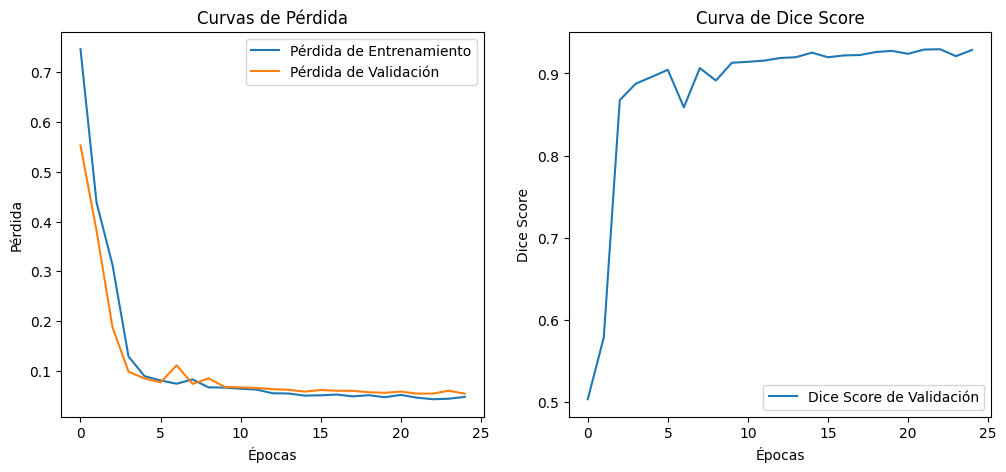

In [31]:
# 5. Visualizar curvas de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Dice Score de Validación')
plt.title('Curva de Dice Score')
plt.xlabel('Épocas')
plt.ylabel('Dice Score')
plt.legend()

plt.show()

In [54]:
# ==============================================================================
# SECCIÓN 8: EVALUACIÓN Y VISUALIZACIÓN DE RESULTADOS (INCLUYENDO XAI)
# ==============================================================================
# Cargar el mejor modelo y visualizar sus predicciones en el conjunto de validación.
# También se aplica Grad-CAM para la interpretabilidad.

def visualize_results_and_gradcam(model, dataset, device, num_samples=5):
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    model.to(device).eval()
    
    class_colors = np.array([
        [  0,   0,   0],  # fondo
        [255,   0,   0],  # NCR
        [  0, 255,   0],  # ED
        [  0,   0, 255],  # ET
    ], dtype=np.uint8)
    target_layers = [model.decoder.blocks[-1].conv2]
    
    for idx in range(min(num_samples, len(dataset))):
        image, gt_mask = dataset[idx]
        image = image.to(device)
        
        # ← CORRECCIÓN aquí
        flair = image[0].cpu().numpy()           # [H, W]
        flair_norm = (flair - flair.min()) / (flair.max() - flair.min() + 1e-8)
        image_rgb  = np.stack([flair_norm]*3, axis=2)  # [H, W, 3]
        
        input_tensor = image.unsqueeze(0)
        with torch.no_grad():
            output    = model(input_tensor)
            pred_mask = torch.softmax(output, dim=1).argmax(dim=1).squeeze().cpu().numpy()
        
        gt_rgb   = class_colors[gt_mask.cpu().numpy()]
        pred_rgb = class_colors[pred_mask]
        
        fig, axes = plt.subplots(1, 6, figsize=(24, 4))
        axes[0].imshow(flair, cmap='gray');        axes[0].set_title('FLAIR');        axes[0].axis('off')
        axes[1].imshow(gt_rgb);                    axes[1].set_title('Máscara Real'); axes[1].axis('off')
        axes[2].imshow(pred_rgb);                  axes[2].set_title('Predicción');   axes[2].axis('off')
        
        cam_idx = 3
        cam_targets = {'NCR (cls 1)':1, 'ED (cls 2)':2, 'ET (cls 3)':3}
        for title, cls in cam_targets.items():
            mask_for_target = (pred_mask == cls).astype(np.uint8)
            targets         = [SemanticSegmentationTarget(mask=mask_for_target, category=cls)]
            with GradCAM(model=model, target_layers=target_layers) as cam:
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
                cam_image     = show_cam_on_image(image_rgb, grayscale_cam, use_rgb=True)
            axes[cam_idx].imshow(cam_image)
            axes[cam_idx].set_title(f'Grad‑CAM {title}')
            axes[cam_idx].axis('off')
            cam_idx += 1
        
        plt.tight_layout()
        plt.show()

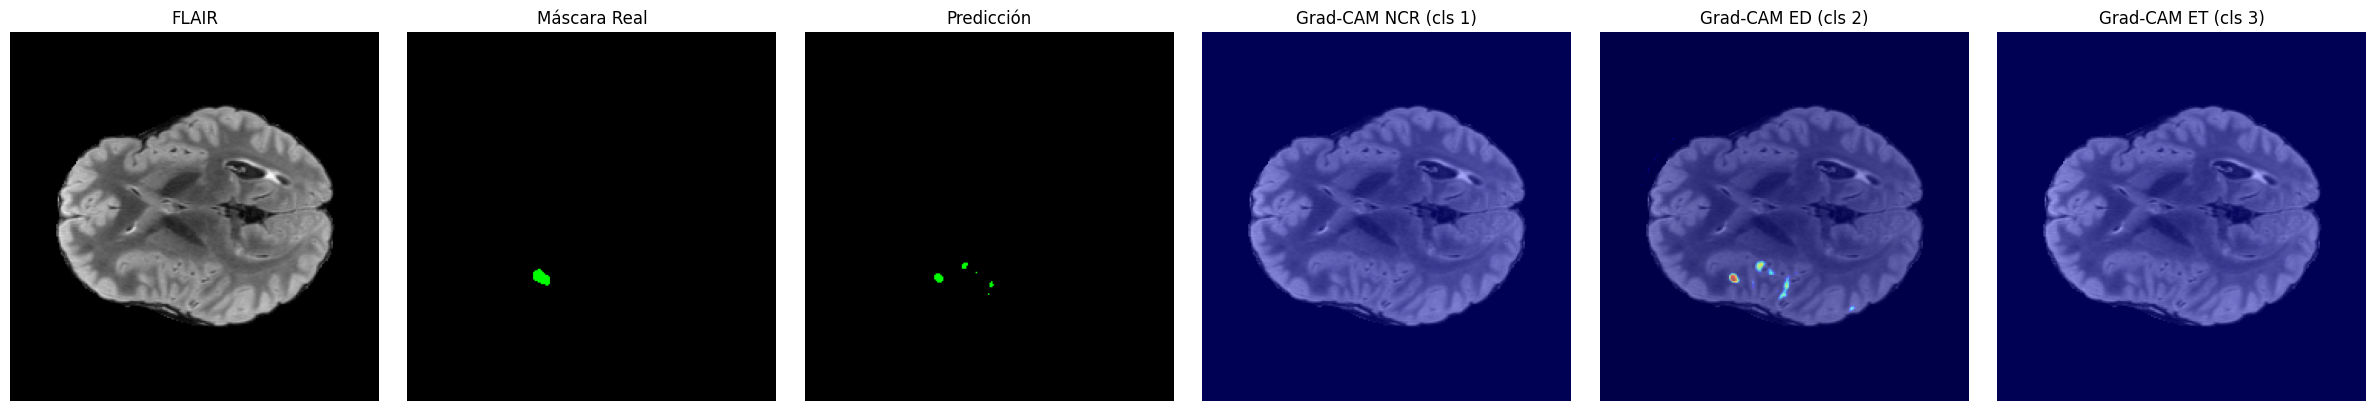

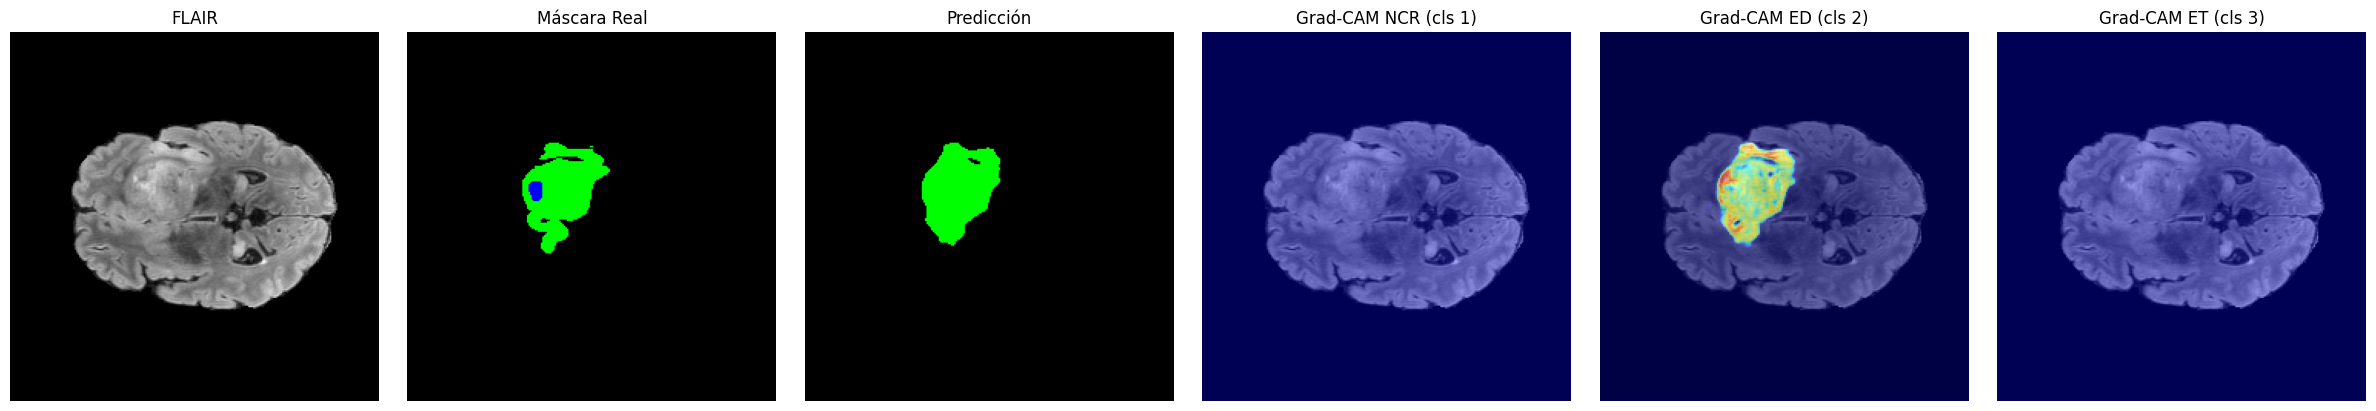

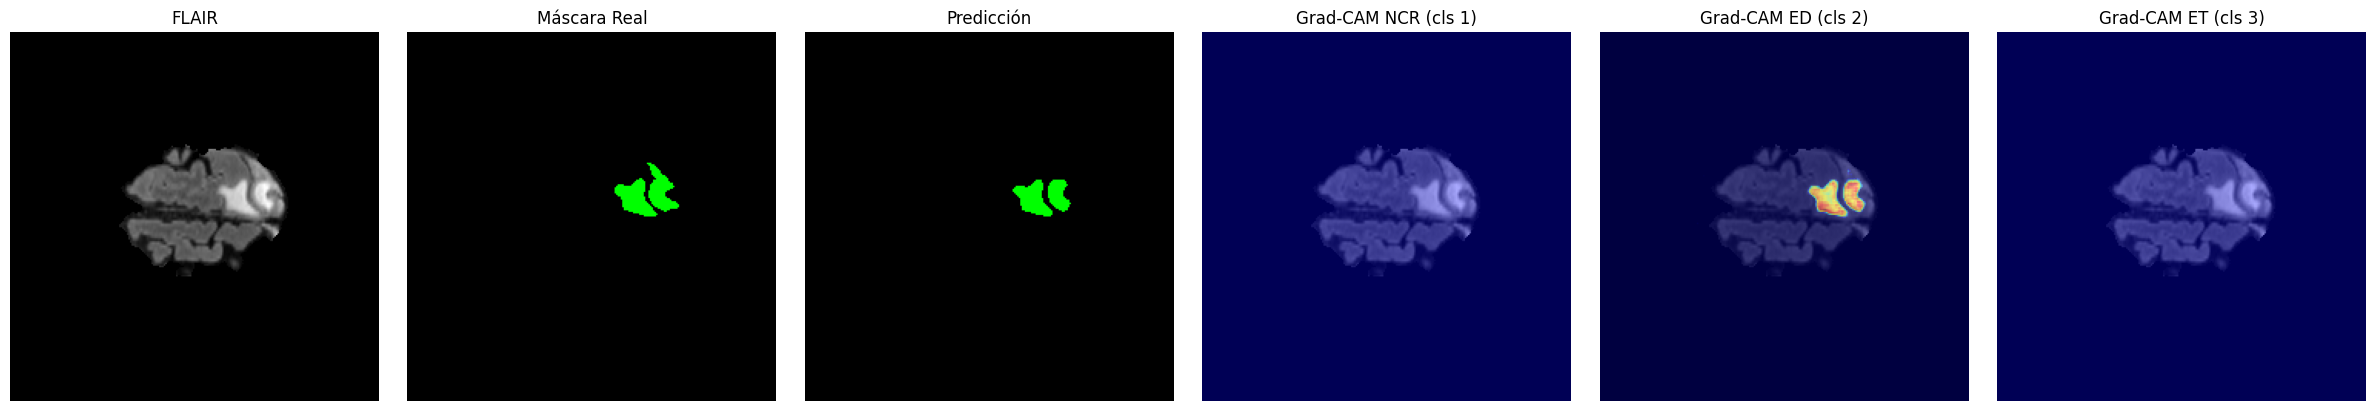

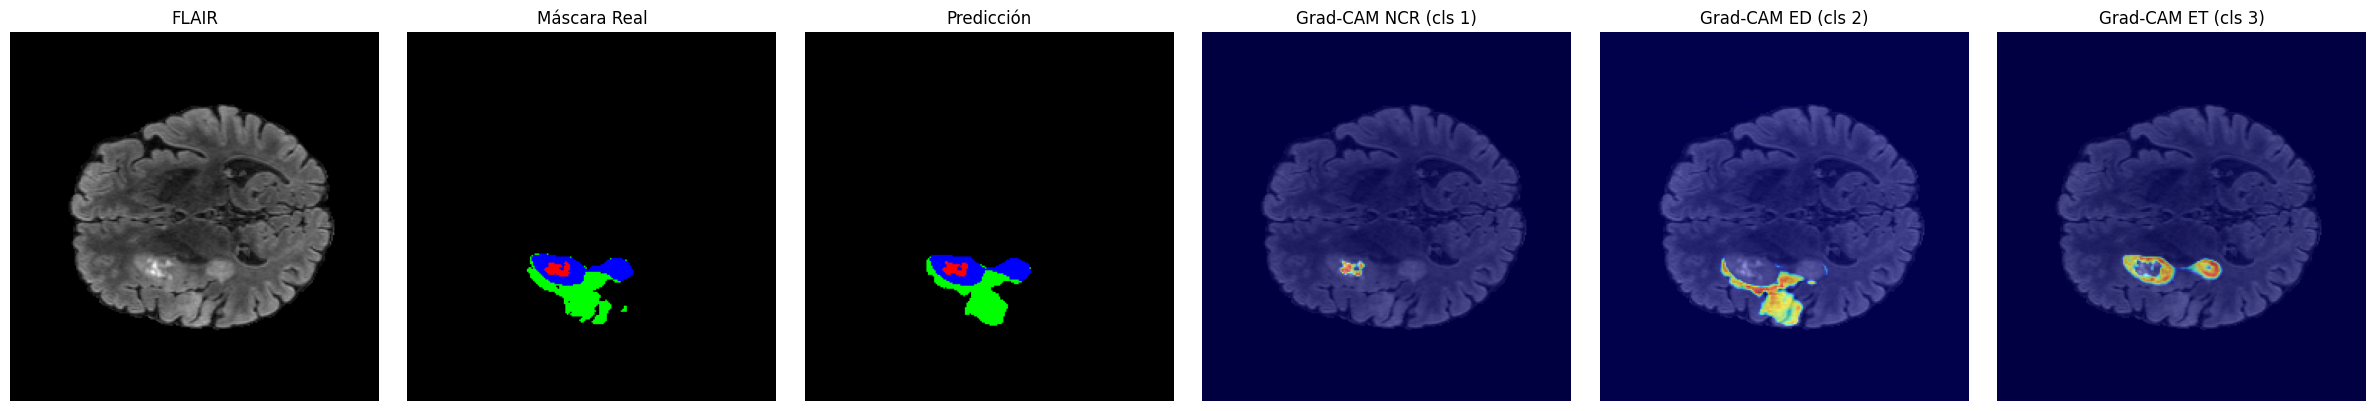

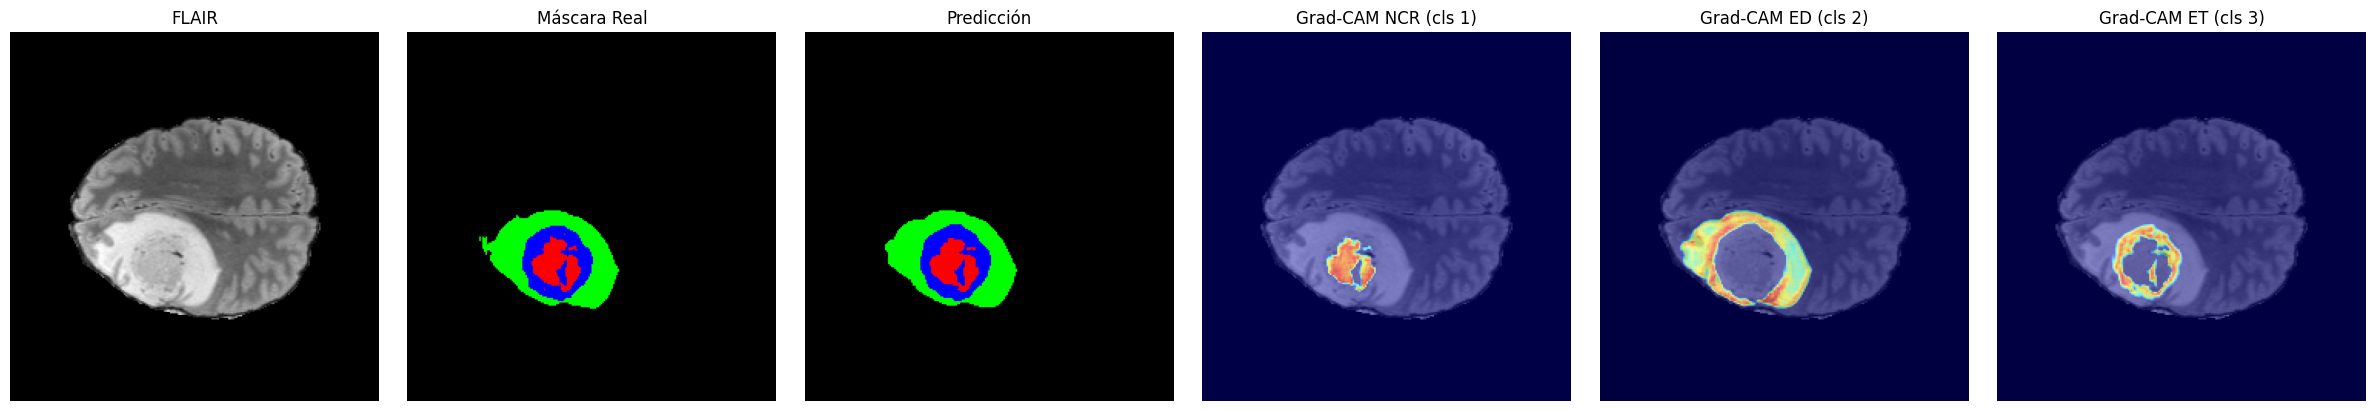

In [55]:
visualize_results_and_gradcam(
    model=model,
    dataset=val_dataset,
    device=DEVICE,
    num_samples=5
)